1. Импорт
2. Определение путей к данным
3. Аугментация данных
4. Обучение модели YOLO
5. Визуализация результатов с расчетом уровня

In [1]:
import os
import cv2
from glob import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
from ultralytics import YOLO
from ultralytics.engine.results import Results, Boxes
import albumentations as A

%matplotlib inline

In [2]:
# Переменные и пути
FENCE_HEIGHT_METERS = 1.1
DATA_ROOT = 'datasets/imagesAnnotatedPolygonal'
TRAIN_DIR = os.path.join(DATA_ROOT, 'train')
VAL_DIR = os.path.join(DATA_ROOT, 'valid')
TEST_DIR = os.path.join(DATA_ROOT, 'test')
OUTPUT_DIR = 'results'

In [3]:
# Создание необходимых директорий
for dir_path in [os.path.join(TRAIN_DIR, 'imagesAugmented'), 
                 os.path.join(TRAIN_DIR, 'labelsAugmented'),
                 os.path.join(VAL_DIR, 'imagesAugmented'),
                 os.path.join(VAL_DIR, 'labelsAugmented'),
                 OUTPUT_DIR]:
    os.makedirs(dir_path, exist_ok=True)

In [4]:
# Определение трансформаций для обучающей выборки
train_transforms = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomSizedCrop(min_max_height=(400, 600), height=480, width=480, p=0.5),
    A.Rotate(limit=10, p=0.65),
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=15, p=0.5),
    A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    A.GaussNoise(var_limit=(10.0, 50.0), p=0.5),
    A.GaussianBlur(blur_limit=(3, 5), p=0.5),
    A.CropAndPad(percent=(-0.2, 0.2), p=0.65, sample_independently=True, keep_size=True),
], keypoint_params=A.KeypointParams(format='xy', remove_invisible=False), 
   bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))

In [5]:
def augment_data(images_dir, labels_dir, augmented_images_dir, augmented_labels_dir, transforms, num_augmentations=5):
    """Аугментация изображений и соответствующих аннотаций."""
    image_paths = glob(os.path.join(images_dir, '*.jpg')) + glob(os.path.join(images_dir, '*.png'))
    for img_path in tqdm(image_paths, desc="Augmenting images"):
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        label_path = os.path.join(labels_dir, os.path.splitext(os.path.basename(img_path))[0] + '.txt')
        if not os.path.exists(label_path):
            continue
        
        with open(label_path, 'r') as f:
            lines = f.readlines()
        
        polygons = []
        class_labels = []
        for line in lines:
            parts = line.strip().split()
            class_id = int(parts[0])
            polygon = [(float(parts[i]), float(parts[i+1])) for i in range(1, len(parts), 2)]
            polygons.append(polygon)
            class_labels.append(class_id)
        
        for i in range(num_augmentations):
            transformed = transforms(image=image, keypoints=[point for polygon in polygons for point in polygon], class_labels=class_labels)
            transformed_image = transformed['image']
            transformed_keypoints = transformed['keypoints']
            
            transformed_polygons = [transformed_keypoints[i:i+len(polygon)] for i, polygon in enumerate(polygons, start=0)]
            
            new_image_name = f"{os.path.splitext(os.path.basename(img_path))[0]}_aug_{i}.jpg"
            cv2.imwrite(os.path.join(augmented_images_dir, new_image_name), cv2.cvtColor(transformed_image, cv2.COLOR_RGB2BGR))
            
            new_label_name = f"{os.path.splitext(os.path.basename(label_path))[0]}_aug_{i}.txt"
            with open(os.path.join(augmented_labels_dir, new_label_name), 'w') as f_out:
                for polygon, class_id in zip(transformed_polygons, class_labels):
                    f_out.write(f"{class_id} {' '.join([f'{x:.6f} {y:.6f}' for x, y in polygon])}\n")

In [6]:
# Аугментация обучающей выборки
augment_data(os.path.join(TRAIN_DIR, 'images'), os.path.join(TRAIN_DIR, 'labels'), 
             os.path.join(TRAIN_DIR, 'imagesAugmented'), os.path.join(TRAIN_DIR, 'labelsAugmented'), 
             train_transforms, num_augmentations=20)

Augmenting images: 100%|██████████| 5/5 [00:03<00:00,  1.56it/s]


In [ ]:
# Загрузка и обучение модели
model = YOLO('yolo11n.pt')
model.train(data=os.path.join(DATA_ROOT, 'data.yaml'), epochs=400, imgsz=640, batch=32, name='yolo11n-liquid-fence-polygonal')

In [7]:
# Загрузка лучшей модели
best_model = YOLO('runs/detect/yolo11n-liquid-fence-polygonal/weights/best.pt')

In [8]:
def crop_image_percent(image, top_percent=10, bottom_percent=10, left_percent=10, right_percent=10):
    """Обрезка изображений на заданный процент с каждой стороны."""
    h, w = image.shape[:2]
    top_crop = int(h * top_percent / 100)
    bottom_crop = int(h * bottom_percent / 100)
    left_crop = int(w * left_percent / 100)
    right_crop = int(w * right_percent / 100)
    return image[top_crop:h-bottom_crop, left_crop:w-right_crop]

def calculate_fill_level(results):
    """Рассчёт уровня заполнения и пустого пространства на основе результатов детекции."""
    fence_box = next((box for box in results[0].boxes if int(box.cls[0]) == 0), None)
    liquid_box = next((box for box in results[0].boxes if int(box.cls[0]) == 1), None)
    
    if fence_box is None or liquid_box is None:
        return None, None, None, None
    
    fence_height_px = fence_box.xyxy[0][3] - fence_box.xyxy[0][1]
    liquid_top = liquid_box.xyxy[0][1]
    fence_bottom = fence_box.xyxy[0][3]
    
    fill_height_px = fence_bottom - liquid_top
    fill_level = fill_height_px / fence_height_px
    
    scale = FENCE_HEIGHT_METERS / fence_height_px
    empty_space_meters = -fill_height_px * scale
    
    return fill_level, fill_height_px, fence_height_px, empty_space_meters

def shift_liquid_box(results, shift_percent=0.1):
    """Смещение bounding box жидкости вверх на заданный процент."""
    new_results = []
    for result in results:
        new_result = Results(orig_img=result.orig_img, path=result.path, names=result.names)
        new_boxes_data = result.boxes.data.clone()
        for i, box in enumerate(new_boxes_data):
            if int(box[5]) == 1:  # класс жидкости
                height = box[3] - box[1]
                shift = height * shift_percent
                new_boxes_data[i, 1] -= shift
                new_boxes_data[i, 3] -= shift
        new_result.boxes = Boxes(new_boxes_data, result.boxes.orig_shape)
        new_results.append(new_result)
    return new_results

def annotate_image(img, fill_level, empty_space_meters, fence_box, liquid_box):
    """Добавление аннотаций на изображение."""
    cv2.putText(img, f"Empty space: {empty_space_meters:.2f} m", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 2)
    
    liquid_center_x = int((liquid_box[0] + liquid_box[2]) / 2)
    start_point = (liquid_center_x, int(fence_box[3]))
    end_point = (liquid_center_x, int(liquid_box[1]))
    cv2.line(img, start_point, end_point, (0, 255, 0), 2)
    
    mid_point = ((start_point[0] + end_point[0]) // 2, (start_point[1] + end_point[1]) // 2)
    cv2.putText(img, f"{empty_space_meters:.2f} m", (mid_point[0] + 10, mid_point[1]), 
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
    
    fence_start = (liquid_center_x, int(fence_box[1]))
    fence_end = (liquid_center_x, int(fence_box[3]))
    cv2.line(img, fence_start, fence_end, (255, 0, 0), 2)
    
    fence_mid_point = ((fence_start[0] + fence_end[0]) // 2, (fence_start[1] + fence_end[1]) // 2)
    cv2.putText(img, f"{FENCE_HEIGHT_METERS:.2f} m", (fence_mid_point[0] + 10, fence_mid_point[1]), 
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 0), 2)
    return img

In [9]:
# Обработка тестовых изображений и визуализация результатов
test_image_paths = glob(os.path.join(TEST_DIR, 'images', '*.jpg')) + glob(os.path.join(TEST_DIR, 'images', '*.png'))


0: 640x544 2 fences, 1 liquid, 38.9ms
Speed: 3.0ms preprocess, 38.9ms inference, 63.8ms postprocess per image at shape (1, 3, 640, 544)

0: 640x544 1 fence, 1 liquid, 11.0ms
Speed: 2.0ms preprocess, 11.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 544)


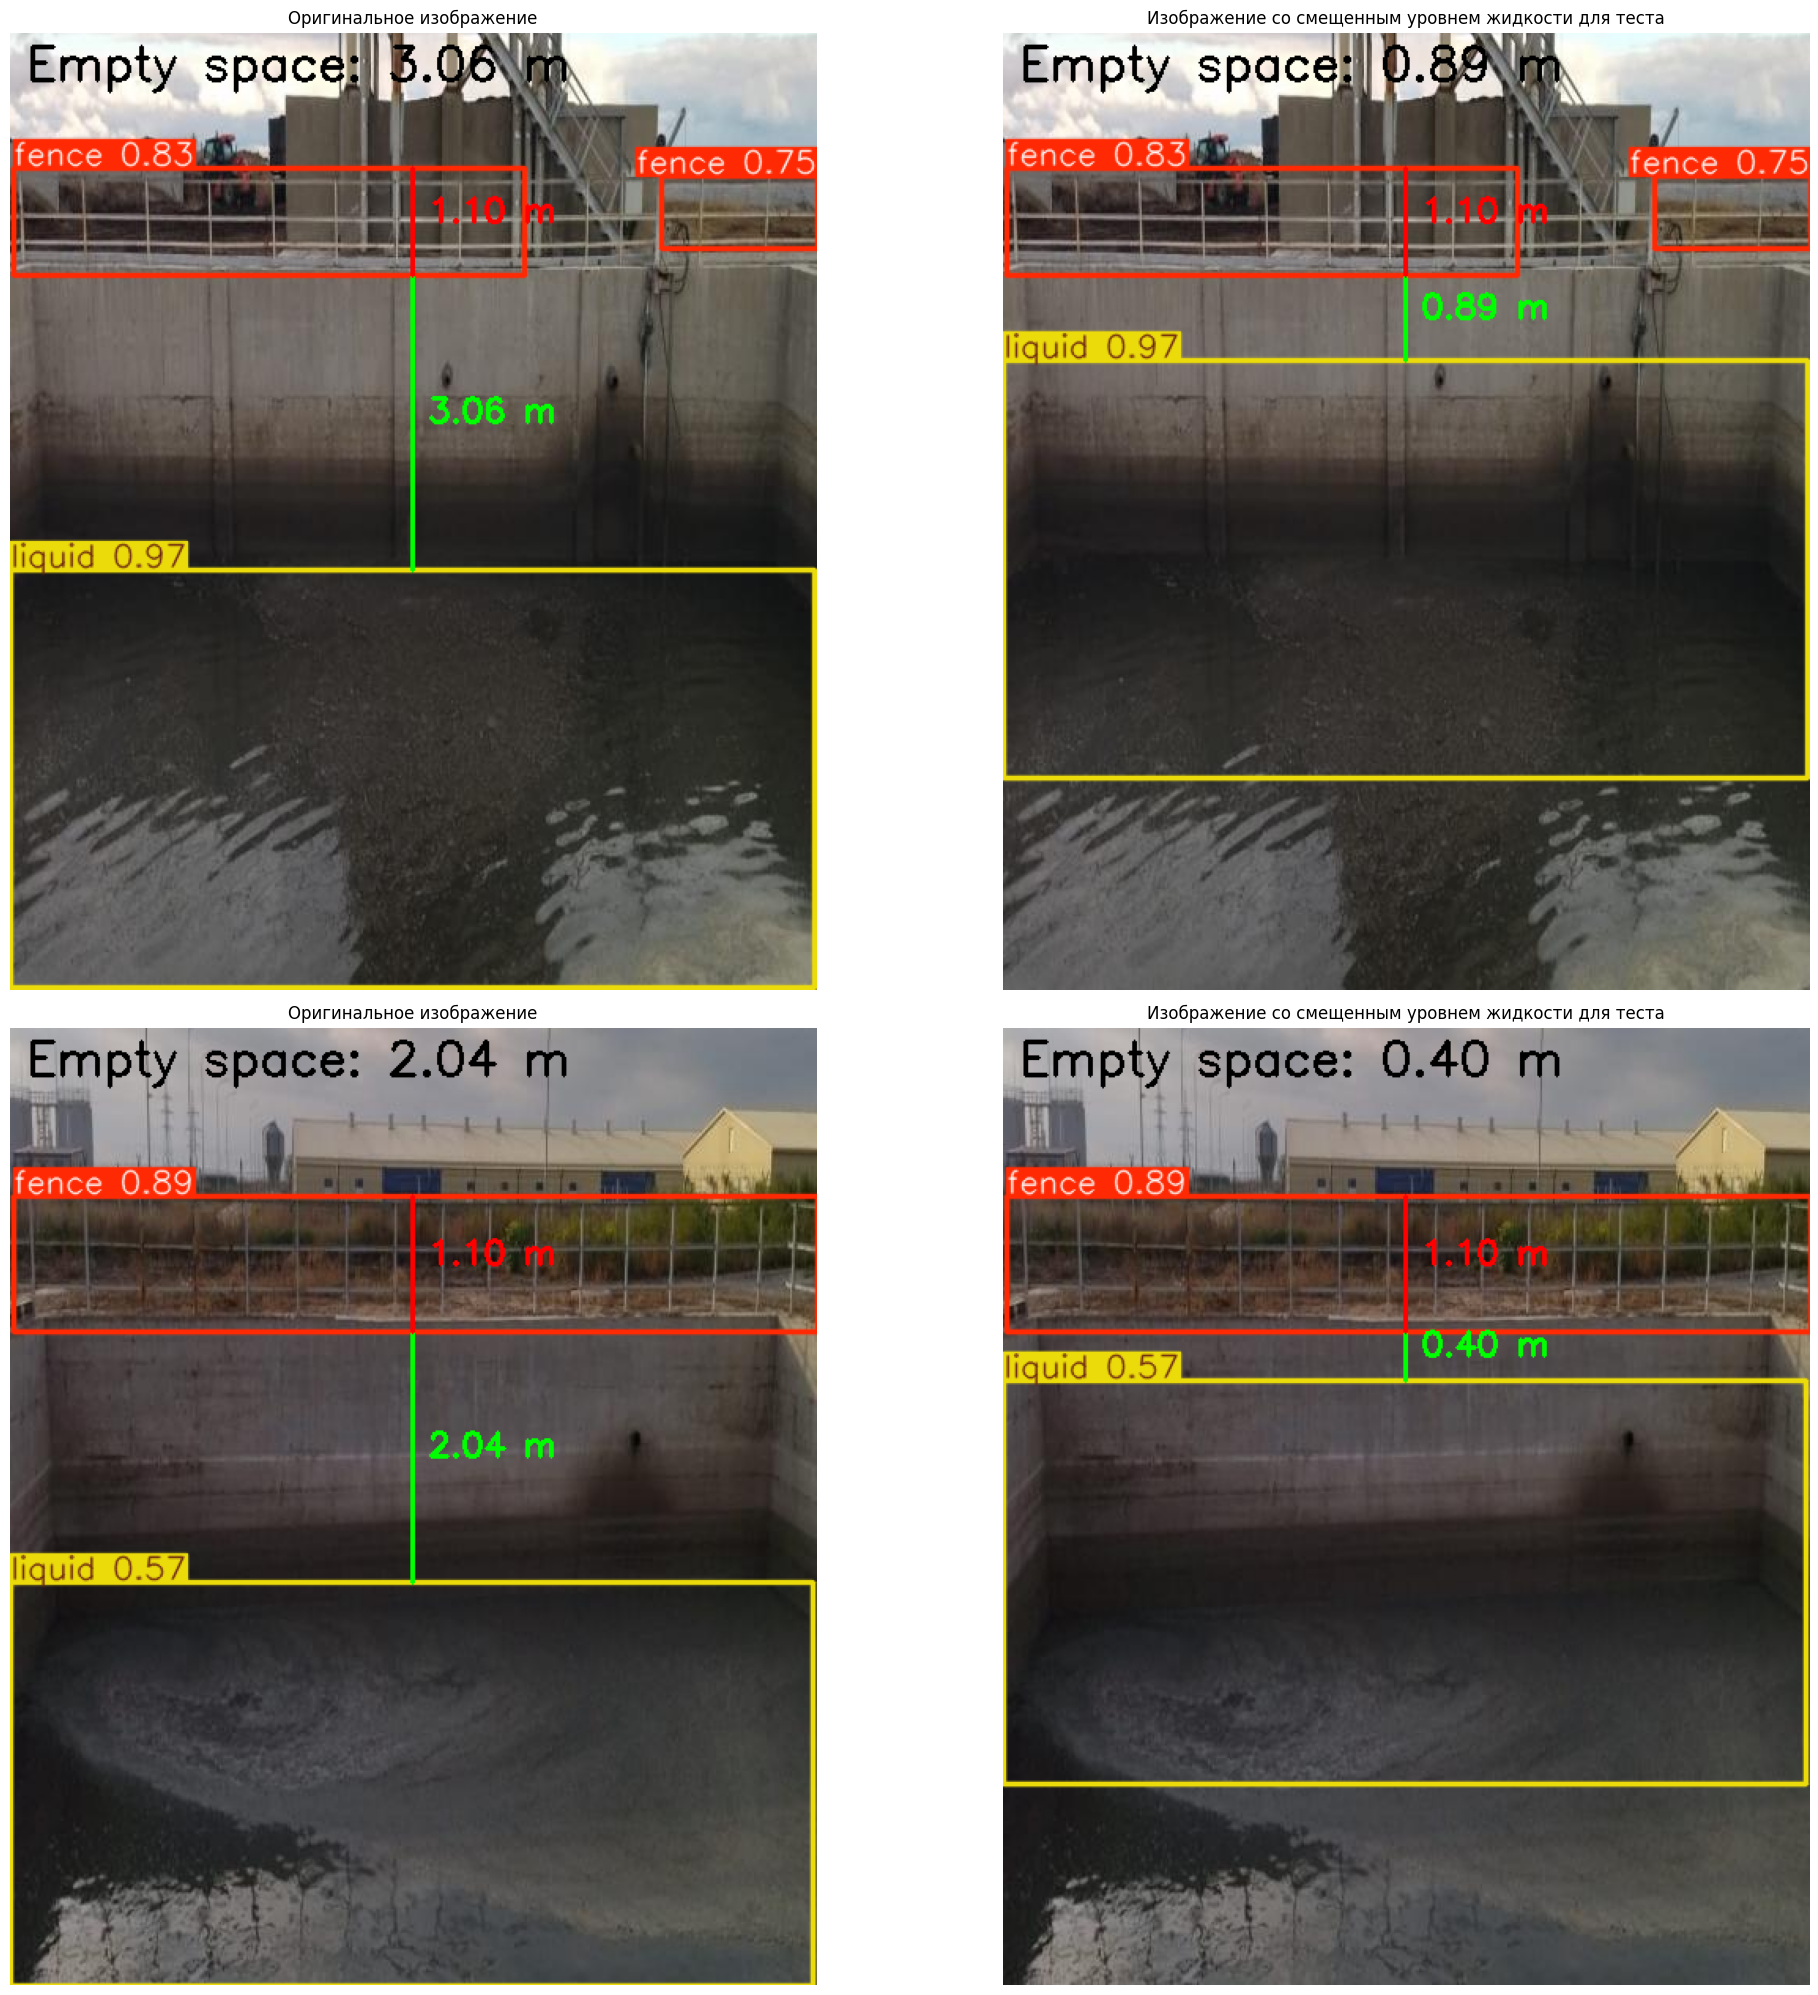

Сравнение оригинальных и модифицированных изображений.


In [10]:
plt.figure(figsize=(20, 30))

for i, img_path in enumerate(test_image_paths):
    original_img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    cropped_img = crop_image_percent(original_img, top_percent=5, bottom_percent=0, left_percent=10, right_percent=10)
    
    results = best_model(source=cropped_img, conf=0.5, save=False)
    
    # Оригинальное изображение
    fill_level, _, _, empty_space_meters = calculate_fill_level(results)
    pred_img = results[0].plot()
    if fill_level is not None:
        fence_box = results[0].boxes[results[0].boxes.cls == 0][0].xyxy[0].tolist()
        liquid_box = results[0].boxes[results[0].boxes.cls == 1][0].xyxy[0].tolist()
        pred_img = annotate_image(pred_img, fill_level, empty_space_meters, fence_box, liquid_box)

    plt.subplot(3, 2, i*2+1)
    plt.imshow(pred_img)
    plt.title('Оригинальное изображение')
    plt.axis('off')
    
    # Изображение со смещенным bounding box
    shifted_results = shift_liquid_box(results, shift_percent=0.5)
    shifted_fill_level, _, _, shifted_empty_space_meters = calculate_fill_level(shifted_results)
    shifted_pred_img = shifted_results[0].plot()
    if shifted_fill_level is not None:
        fence_box = shifted_results[0].boxes[shifted_results[0].boxes.cls == 0][0].xyxy[0].tolist()
        liquid_box = shifted_results[0].boxes[shifted_results[0].boxes.cls == 1][0].xyxy[0].tolist()
        shifted_pred_img = annotate_image(shifted_pred_img, shifted_fill_level, shifted_empty_space_meters, fence_box, liquid_box)

    plt.subplot(3, 2, i*2+2)
    plt.imshow(shifted_pred_img)
    plt.title('Изображение со смещенным уровнем жидкости для теста')
    plt.axis('off')

plt.tight_layout()
plt.show()

print(f"Сравнение оригинальных и модифицированных изображений.")